# Example 1: fitting $\mu, \sigma - SNR$ relation, and initializing

In seal, prior distribution of $A_{ij}$ is SNR-dependent: 

$p(A_{ij}) \propto N(-\mu, \sigma^2) + N(\mu, \sigma^2)$

where $N$ is Gaussian distribution and $\mu, \sigma$ are SNR-dependent coefficients. SNR, on the other hand, is dependent on detector configuration. The relation should be pre-trained before localization. We found an useful approximation of this relation for all PSD and detector network:

$\mu = a*SNR + b$, and $\sigma = c*SNR + d$.

This script shows how to get $a,b,c,d$ for your configuration (detector network and PSD), and store it for next-time use.

The interface of seal is the class "Seal", it contains the basic properties of our localization method: $a,b,c,d$. With these coefficients you can localize GW event (see next examples). However if $a,b,c,d$ are not given, we need to fit them before localization. The fitting only need to be done once as long as your configuration is not chenged.

Before localization, you need also to initialized the Seal. If it is trained just now then it is already initialized. Otherwise, we need to read from a file you stored or manually initialized it.

In [1]:
import bilby
import numpy as np 
import time
import sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import multiprocessing
from functools import partial
from matplotlib.pyplot import MultipleLocator
from bilby.gw import conversion
from scipy.optimize import leastsq
import json

import sealgw
from sealgw import seal

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


# Fitting with bilby default PSDs (design sensitivity)

If you are doing injection with bilby, then bilby itself stores some PSDs. Here we use its L+H+V network.

In [2]:
# Set a seal, it is not initialized yet.
seal_bilby_design_lhv = seal.Seal()

print(seal_bilby_design_lhv.initialized)
print(seal_bilby_design_lhv.description)

False
An uninitialized seal.


11:50 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


Computing SNR...
Fitting mu-sigma-SNR relation...
Fitting done!
a = 0.00014631100198131416
b = 0.0011989501405180337
c = 8.944861158825739e-05
d = 0.0011146923908746333


<Figure size 432x288 with 0 Axes>

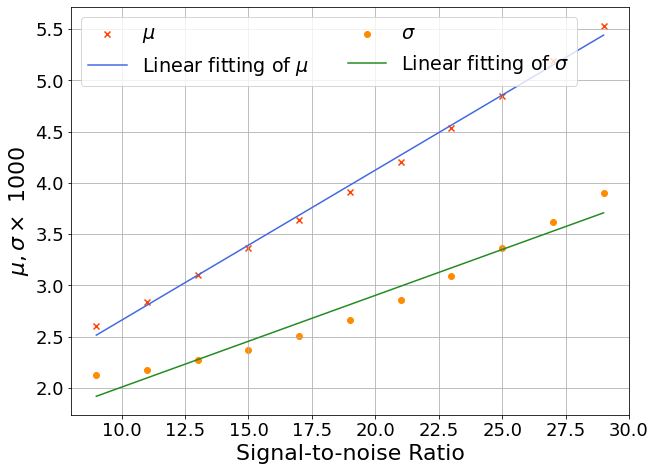

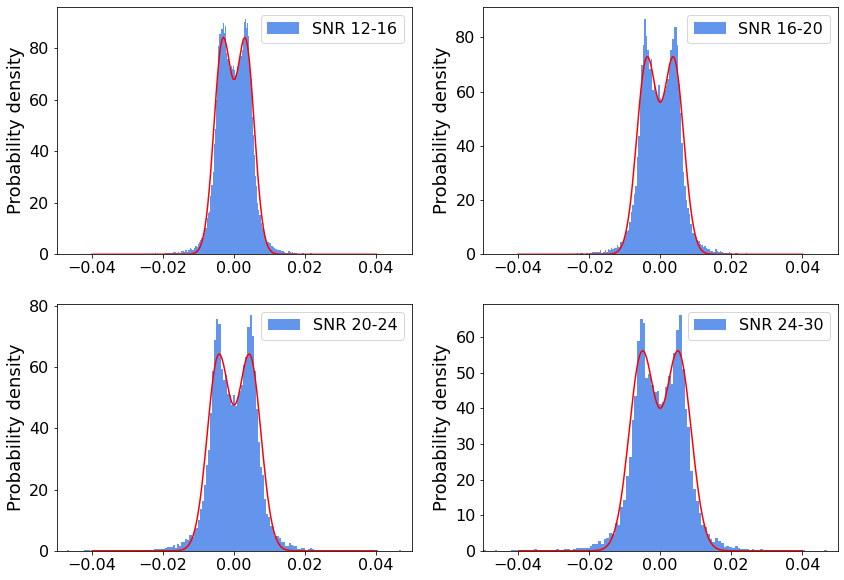

In [3]:
# Now fit the relation. 
# Use "seal_bilby_design_lhv.fitting_mu_sigma_snr_relation?" to see what parameters you can set.

Nsample = 30000
det_name_list = ['L1', 'H1', 'V1']
source_type = "BNS"
ncpu = 6
plotsave = ['example_outputs/linear_fitting.png', 'example_outputs/bimodal_fitting.png'] 
seal_bilby_design_lhv.fitting_mu_sigma_snr_relation(Nsample=Nsample, det_name_list=det_name_list, source_type=source_type, ncpu=ncpu,
                               plotsave=plotsave)

Done! It takes ~1min on my laptop, using 6 cpus.

In general, I recommend Nsample>30000 for an accurate fitting, it won't take too long anyway.

The two plots are saved to the path we set.

You can access these coefficients by:


In [4]:
print(seal_bilby_design_lhv.prior_coef_a)
print(seal_bilby_design_lhv.description)
print(seal_bilby_design_lhv.initialized)
# You can see it's now initialized.

0.00014631100198131416
Seal trained with bilby PSD for L1 H1 V1 
True


# Fitting with your own PSD

You may want to fit with PSDs that are not stored in bilby: simply disable bilby PSD and set your own PSD path.

The psd file should be plain text, with 2 colunms. 1st for frequency, 2nd for PSD (not ASD). 

11:53 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


Computing SNR...
Fitting mu-sigma-SNR relation...
Fitting done!
a = 0.0004418822664215375
b = -4.622029091407209e-06
c = 0.00037132230497101263
d = -0.0008973225587166593


<Figure size 432x288 with 0 Axes>

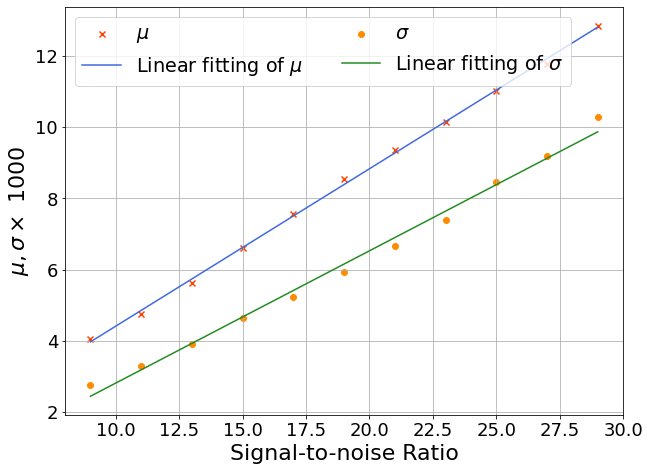

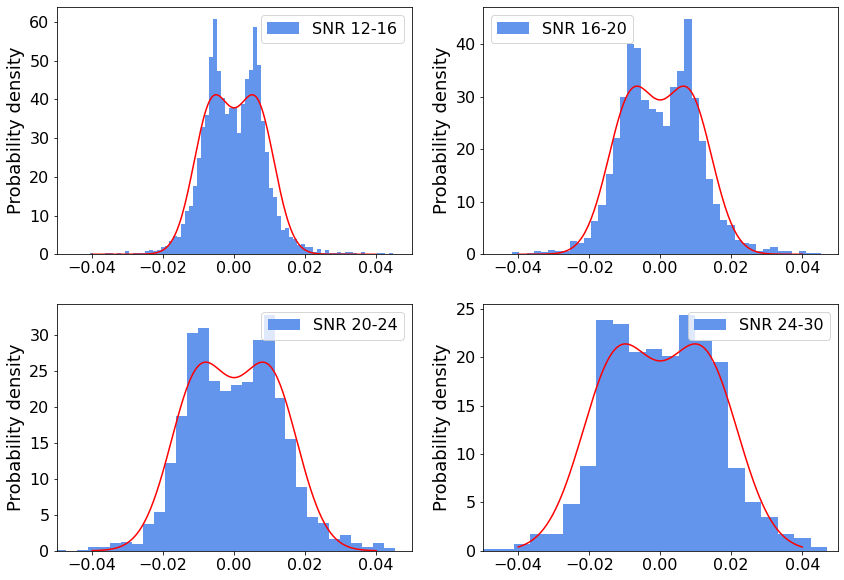

In [5]:
seal_O2_lhv = seal.Seal()

Nsample = 30000
det_name_list = ['L1', 'H1', 'V1']
# psd files should be the same squence as in det_name_list
psd_files = ['example_inputs/L1_psd.txt','example_inputs/H1_psd.txt','example_inputs/V1_psd.txt']

source_type = "BNS"
ncpu = 6
plotsave = ['example_outputs/linear_fitting_custom.png', 'example_outputs/bimodal_fitting_custom.png'] 

seal_O2_lhv.fitting_mu_sigma_snr_relation(Nsample=Nsample, det_name_list=det_name_list, source_type=source_type, ncpu=ncpu,
                               plotsave=plotsave, use_bilby_psd = False, custom_psd_path = psd_files)

# Storing and loading your fitting result

The fitting result can be saved as a file and be read when you use it, so that you don't need to copy $a,b,c,d$ to your code and manually initialize the seal (you can do this if you prefer, as I will show in the end).

In [6]:
# Store the seal you just fit
seal_bilby_design_lhv.save_config_dict('example_outputs/sealconfig_bilby_lhv_BNS.txt')
seal_O2_lhv.save_config_dict('example_outputs/sealconfig_O2_lhv_BNS.txt')

In [7]:
# Next time you can read it
seal_new = seal.Seal(config_dict="example_outputs/sealconfig_O2_lhv_BNS.txt")

print(seal_new.prior_coef_a)
print(seal_new.description)
print(seal_new.initialized)


0.0004418822664215375
Seal trained with own PSD for L1 H1 V1 
True


# Manually initialize seal

Alternatively you can note the coefficients somewhere, write a dictionary and manually intialized your seal

In [8]:
config_dict = {'description': "my seal with xxx config",
              'a': 1,
              'b': 1,
              'c': 1,
              'd': 1,} # These coefficient are not realistic

seal_manually_initialized = seal.Seal(config_dict=config_dict)

In [9]:
print(seal_manually_initialized.initialized)
print(seal_manually_initialized.description)
print(seal_manually_initialized.prior_coef_a)


True
my seal with xxx config
1
